In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Airtel\GM Combiner")

# Read Data

In [3]:
##read datasets
df=pd.read_pickle(os.getcwd()+r"\Data Files\airtel_woe.pkl").reset_index()
df1 = pd.read_csv(os.getcwd()+r"\Data Files\ALL_GM_SCORES.csv")

df2= pd.read_csv(os.getcwd()+r'\Data Files\export_with_backscored.CSV')[["SKP_CREDIT_CASE","RISK_FPD10","RISK_FPD30","RISK_FSPD30","RISK_FSTPD30","FLAG_1PCT_PHANTOM","RISK_AGRF10","RISK_AGRF30","RISK_AGRF60","RISK_AGRF90"]]

df= df.merge(df1, on = 'SKP_CREDIT_CASE')
df= df.merge(df2, on = 'SKP_CREDIT_CASE')

In [4]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,AIRTEL_SCORE,AIRTEL_SCORE_WOE,DND,VODAFONE,PAYU,GEO,INTERNAL,PRODUCT,...,POS_AU20_GM_WO_PP_LR,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,FLAG_1PCT_PHANTOM,RISK_AGRF10,RISK_AGRF30,RISK_AGRF60,RISK_AGRF90
0,308713952,2020-06-25,0.217196,-0.494191,-2.630188,-3.131907,-0.026942,0.032083,-1.059927,-2.580669,...,-3.240736,0,0,0,0,1,1,1,1,1
1,308112356,2020-06-16,NaN,-0.019566,-2.796292,-2.989024,-0.026942,0.032083,-1.650157,-2.228752,...,-3.591045,0,0,0,0,1,1,1,1,1
2,308827470,2020-06-26,NaN,-0.019566,-2.630188,-3.131907,0.374091,0.032083,-2.082420,-2.010056,...,-4.484315,0,0,0,0,1,1,1,1,1
3,308825412,2020-06-26,NaN,-0.019566,-2.630188,-3.131907,-0.026942,-0.228968,-1.714480,-2.521566,...,-3.536626,0,0,0,1,1,1,1,1,1
4,308778576,2020-06-26,0.154841,-0.134121,-2.458118,-3.131907,-0.026942,0.032083,-1.824684,-2.521566,...,-3.746982,0,0,1,1,1,1,1,1,1


In [5]:
df.dropna(subset = ['AIRTEL_SCORE'], inplace = True)

In [6]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [7]:
def lift_and_gain_df(data=None,target=None, prob=None, bucket = 10):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), bucket)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped.agg(['min'])[prob].iloc[:,0]
    liftstable['max_prob'] = grouped.agg(['max'])[prob].iloc[:,0]
    liftstable['total']   = grouped.agg(['count'])[target].iloc[:,0]
    liftstable['bads']   = round(grouped.agg(['sum'])[target].iloc[:,0])
    liftstable['goods'] = round(grouped.agg(['sum'])['target0'].iloc[:,0])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

# FPD30

# POS_AUG20_GM_LGBM

In [8]:
hcc_score='POS_AUG20_GM_LGBM'
target = 'RISK_FPD30'
observable = 'RISK_AGRF30'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

In [9]:
data = df.dropna(subset = [hcc_score])
data = data[data[observable]==1]

data["MONTH"]= data[TIME_DECISION_DATE].dt.strftime("%y-%m")
data = data[data["MONTH"].isin(['20-11','20-12'])]

In [10]:
df_summ = data.groupby("MONTH").aggregate(["count","sum"])[target]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

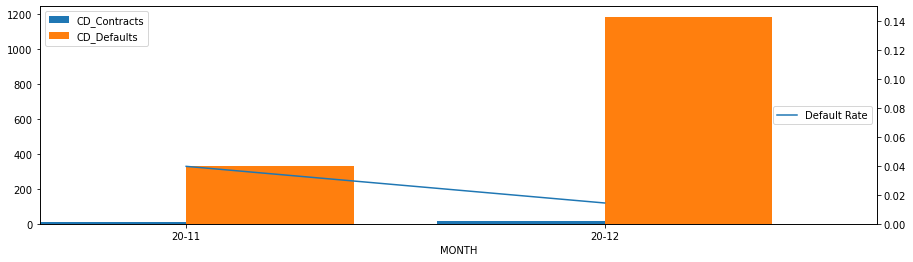

In [11]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [12]:
data["COMBINED_SCORE_WITH_AIRTEL"] = data[hcc_score] - 0.8*data["AIRTEL_SCORE_WOE"]
data["AIRTEL_SCORE_WOE"] = data["AIRTEL_SCORE_WOE"]*-1

In [13]:
FINAL_SCORE = "AIRTEL_SCORE_WOE"
RISK_SCORE = hcc_score
COMBINED_SCORE = "COMBINED_SCORE_WITH_AIRTEL"
TARGET = target

### Gini Chart

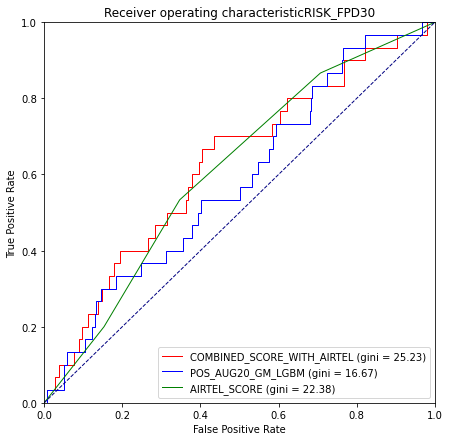

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(data[TARGET],data[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_AIRTEL (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=RISK_SCORE+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic' + TARGET)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [15]:

gini_dic = {}
for x in data["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


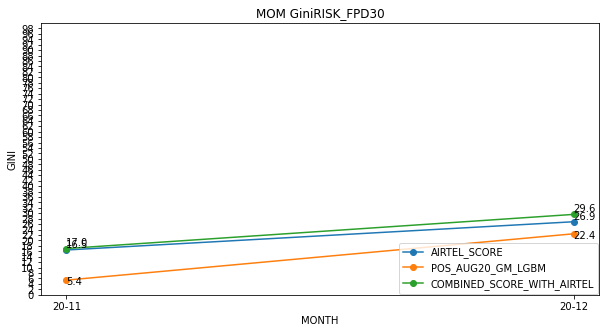

In [16]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[FINAL_SCORE], marker='o', scaley = False, label = "AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = RISK_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[COMBINED_SCORE], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_AIRTEL")

for i, txt in enumerate(gini_df[FINAL_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[FINAL_SCORE][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df[COMBINED_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[COMBINED_SCORE][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini" + TARGET)
plt.show()

## Lifts and Gains Chart

In [17]:
#cum%_bads is gain_score
combined_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=COMBINED_SCORE, bucket=10)
risk_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=RISK_SCORE, bucket=10)
airtel_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=FINAL_SCORE, bucket=10)

### Cumulative Lift Chart 

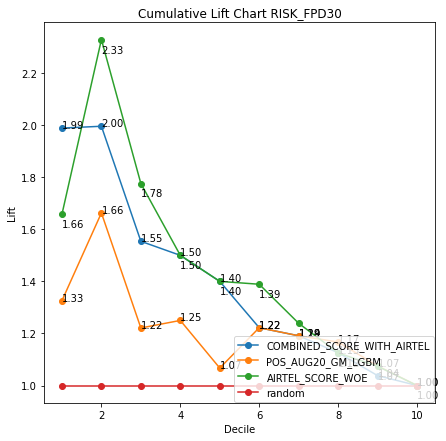

In [18]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


    
ax1.plot(combined_score_lift.index,combined_score_lift["cum_lift"], label = COMBINED_SCORE, marker='o')
for i, txt in enumerate(combined_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_lift.index[i], combined_score_lift["cum_lift"][i+1]))

ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = RISK_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(airtel_score_lift.index,airtel_score_lift["cum_lift"], label = FINAL_SCORE, marker='o')
for i, txt in enumerate(airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (airtel_score_lift.index[i], airtel_score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+TARGET)
plt.show()    


# POS_AUG20_GM_LR

In [19]:
hcc_score='POS_AUG20_GM_LR'
target = 'RISK_FPD30'
observable = 'RISK_AGRF30'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

In [20]:
data = df.dropna(subset = [hcc_score])
data = data[data[observable]==1]

data["MONTH"]= data[TIME_DECISION_DATE].dt.strftime("%y-%m")
data = data[data["MONTH"].isin(['20-11','20-12'])]

In [21]:
df_summ = data.groupby("MONTH").aggregate(["count","sum"])[target]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

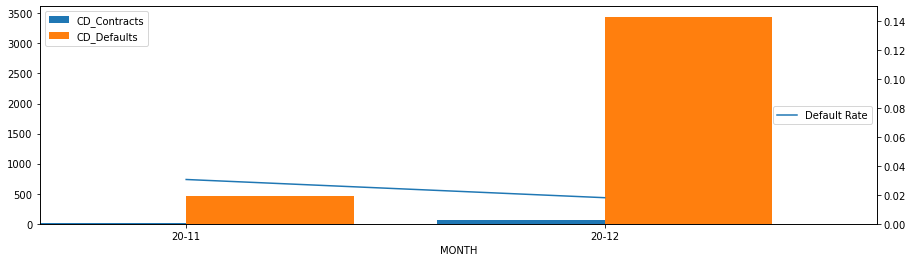

In [22]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [23]:
data["COMBINED_SCORE_WITH_AIRTEL"] = data[hcc_score] - 0.8*data["AIRTEL_SCORE_WOE"]
data["AIRTEL_SCORE_WOE"] = data["AIRTEL_SCORE_WOE"]*-1

In [24]:
FINAL_SCORE = "AIRTEL_SCORE_WOE"
RISK_SCORE = hcc_score
COMBINED_SCORE = "COMBINED_SCORE_WITH_AIRTEL"
TARGET = target

### Gini Chart

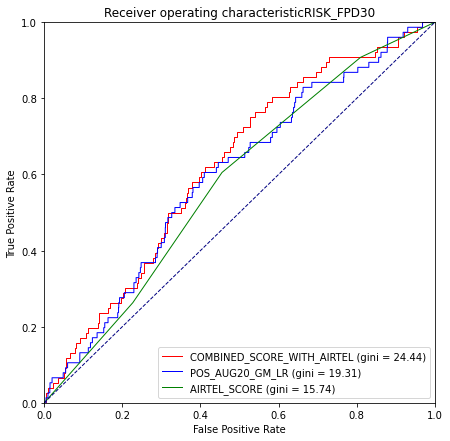

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(data[TARGET],data[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_AIRTEL (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=RISK_SCORE+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic' + TARGET)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [26]:

gini_dic = {}
for x in data["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


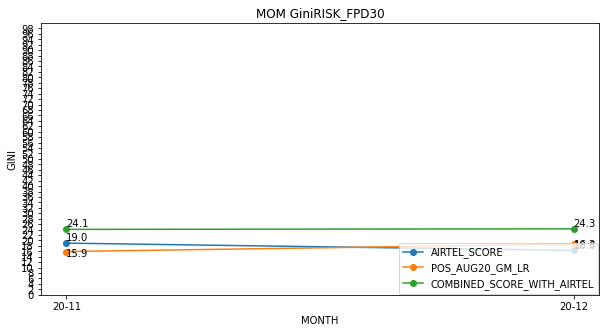

In [27]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[FINAL_SCORE], marker='o', scaley = False, label = "AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = RISK_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[COMBINED_SCORE], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_AIRTEL")

for i, txt in enumerate(gini_df[FINAL_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[FINAL_SCORE][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df[COMBINED_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[COMBINED_SCORE][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini" + TARGET)
plt.show()

## Lifts and Gains Chart

In [28]:
#cum%_bads is gain_score
combined_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=COMBINED_SCORE, bucket=10)
risk_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=RISK_SCORE, bucket=10)
airtel_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=FINAL_SCORE, bucket=10)

### Cumulative Lift Chart 

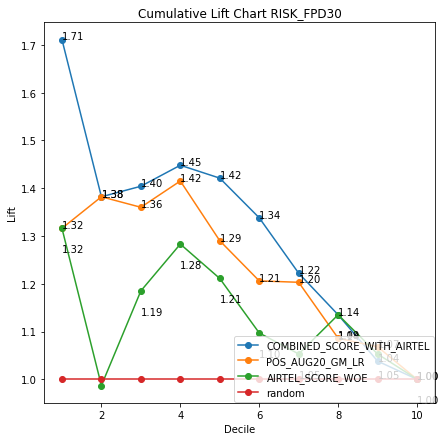

In [29]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


    
ax1.plot(combined_score_lift.index,combined_score_lift["cum_lift"], label = COMBINED_SCORE, marker='o')
for i, txt in enumerate(combined_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_lift.index[i], combined_score_lift["cum_lift"][i+1]))

ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = RISK_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(airtel_score_lift.index,airtel_score_lift["cum_lift"], label = FINAL_SCORE, marker='o')
for i, txt in enumerate(airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (airtel_score_lift.index[i], airtel_score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+TARGET)
plt.show()    


# POS_AUG20_GM_WO_PP_LGBM

In [30]:
hcc_score='POS_AU20_GM_WO_PP_LGBM'
target = 'RISK_FPD30'
observable = 'RISK_AGRF30'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

In [31]:
data = df.dropna(subset = [hcc_score])
data = data[data[observable]==1]

data["MONTH"]= data[TIME_DECISION_DATE].dt.strftime("%y-%m")
data = data[data["MONTH"].isin(['20-11','20-12'])]

In [32]:
df_summ = data.groupby("MONTH").aggregate(["count","sum"])[target]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

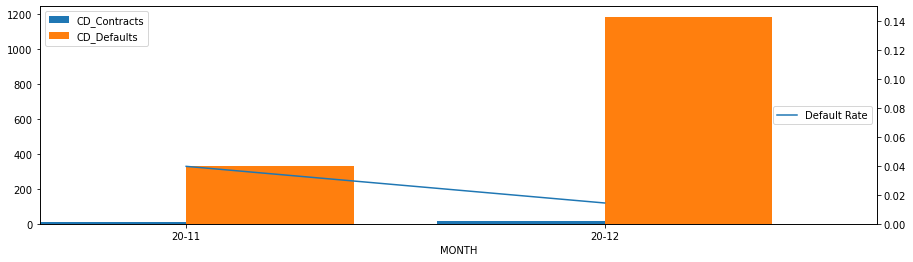

In [33]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [34]:
data["COMBINED_SCORE_WITH_AIRTEL"] = data[hcc_score] - 0.8*data["AIRTEL_SCORE_WOE"]
data["AIRTEL_SCORE_WOE"] = data["AIRTEL_SCORE_WOE"]*-1

In [35]:
FINAL_SCORE = "AIRTEL_SCORE_WOE"
RISK_SCORE = hcc_score
COMBINED_SCORE = "COMBINED_SCORE_WITH_AIRTEL"
TARGET = target

### Gini Chart

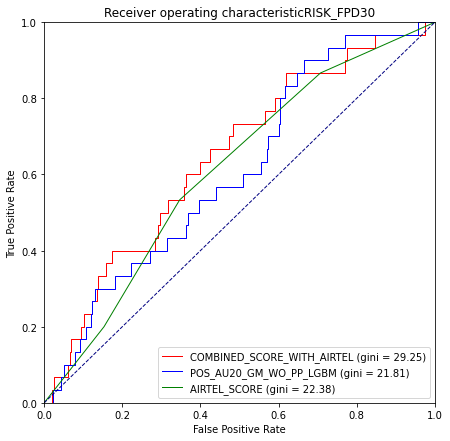

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(data[TARGET],data[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_AIRTEL (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=RISK_SCORE+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic' + TARGET)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [37]:

gini_dic = {}
for x in data["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


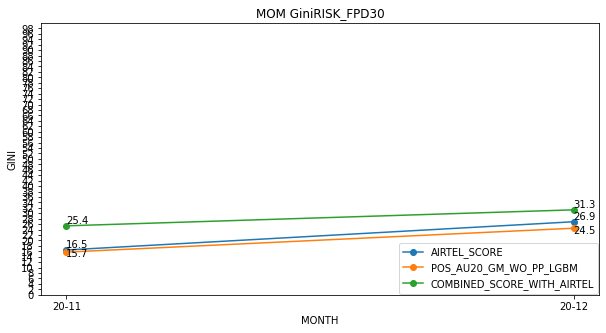

In [38]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[FINAL_SCORE], marker='o', scaley = False, label = "AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = RISK_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[COMBINED_SCORE], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_AIRTEL")

for i, txt in enumerate(gini_df[FINAL_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[FINAL_SCORE][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df[COMBINED_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[COMBINED_SCORE][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini" + TARGET)
plt.show()

## Lifts and Gains Chart

In [39]:
#cum%_bads is gain_score
combined_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=COMBINED_SCORE, bucket=10)
risk_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=RISK_SCORE, bucket=10)
airtel_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=FINAL_SCORE, bucket=10)

### Cumulative Lift Chart 

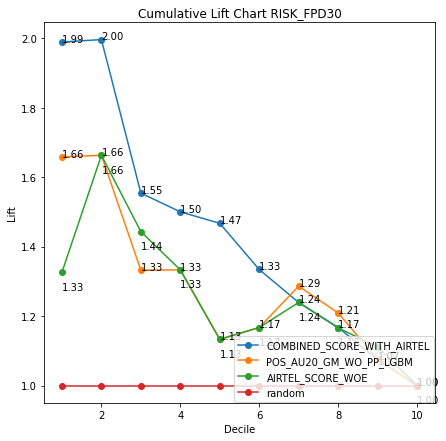

In [40]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


    
ax1.plot(combined_score_lift.index,combined_score_lift["cum_lift"], label = COMBINED_SCORE, marker='o')
for i, txt in enumerate(combined_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_lift.index[i], combined_score_lift["cum_lift"][i+1]))

ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = RISK_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(airtel_score_lift.index,airtel_score_lift["cum_lift"], label = FINAL_SCORE, marker='o')
for i, txt in enumerate(airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (airtel_score_lift.index[i], airtel_score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+TARGET)
plt.show()    


# POS_AUG20_GM_WO_PP_LR

In [41]:
hcc_score='POS_AU20_GM_WO_PP_LR'
target = 'RISK_FPD30'
observable = 'RISK_AGRF30'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

In [42]:
data = df.dropna(subset = [hcc_score])
data = data[data[observable]==1]

data["MONTH"]= data[TIME_DECISION_DATE].dt.strftime("%y-%m")
data = data[data["MONTH"].isin(['20-11','20-12'])]

In [43]:
df_summ = data.groupby("MONTH").aggregate(["count","sum"])[target]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

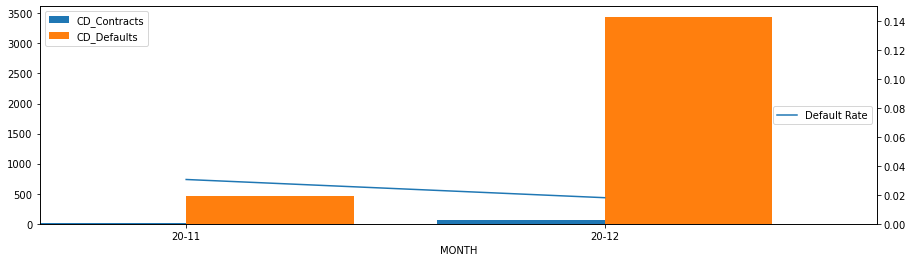

In [44]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [45]:
data["COMBINED_SCORE_WITH_AIRTEL"] = data[hcc_score] - 0.8*data["AIRTEL_SCORE_WOE"]
data["AIRTEL_SCORE_WOE"] = data["AIRTEL_SCORE_WOE"]*-1

In [46]:
FINAL_SCORE = "AIRTEL_SCORE_WOE"
RISK_SCORE = hcc_score
COMBINED_SCORE = "COMBINED_SCORE_WITH_AIRTEL"
TARGET = target

### Gini Chart

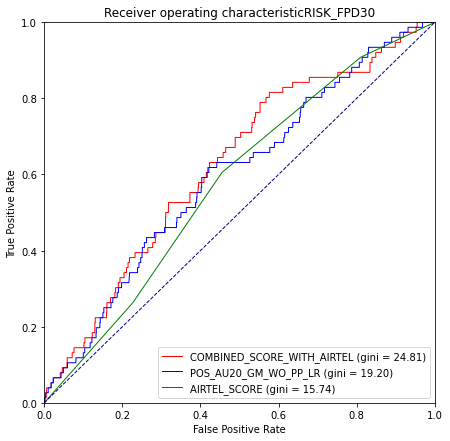

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(data[TARGET],data[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_AIRTEL (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=RISK_SCORE+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic' + TARGET)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [48]:

gini_dic = {}
for x in data["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


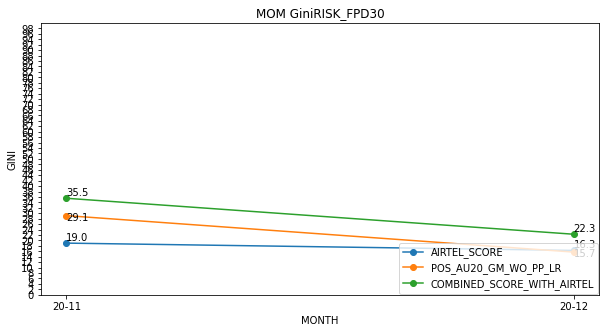

In [49]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[FINAL_SCORE], marker='o', scaley = False, label = "AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = RISK_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[COMBINED_SCORE], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_AIRTEL")

for i, txt in enumerate(gini_df[FINAL_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[FINAL_SCORE][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df[COMBINED_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[COMBINED_SCORE][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini" + TARGET)
plt.show()

## Lifts and Gains Chart

In [50]:
#cum%_bads is gain_score
combined_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=COMBINED_SCORE, bucket=10)
risk_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=RISK_SCORE, bucket=10)
airtel_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=FINAL_SCORE, bucket=10)

### Cumulative Lift Chart 

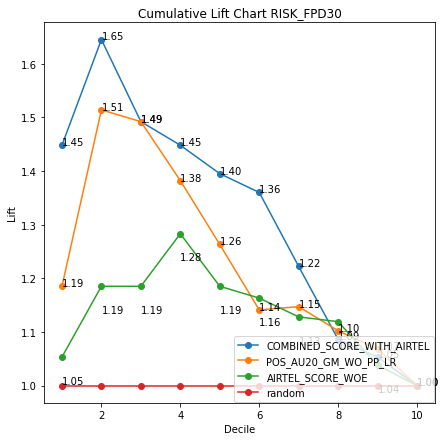

In [51]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


    
ax1.plot(combined_score_lift.index,combined_score_lift["cum_lift"], label = COMBINED_SCORE, marker='o')
for i, txt in enumerate(combined_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_lift.index[i], combined_score_lift["cum_lift"][i+1]))

ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = RISK_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(airtel_score_lift.index,airtel_score_lift["cum_lift"], label = FINAL_SCORE, marker='o')
for i, txt in enumerate(airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (airtel_score_lift.index[i], airtel_score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+TARGET)
plt.show()    


# FPD10

# POS_AUG20_GM_LGBM

In [52]:
hcc_score='POS_AUG20_GM_LGBM'
target = 'RISK_FPD10'
observable = 'RISK_AGRF10'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

In [53]:
data = df.dropna(subset = [hcc_score])
data = data[data[observable]==1]

data["MONTH"]= data[TIME_DECISION_DATE].dt.strftime("%y-%m")
data = data[data["MONTH"].isin(['20-11','20-12'])]

In [54]:
df_summ = data.groupby("MONTH").aggregate(["count","sum"])[target]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

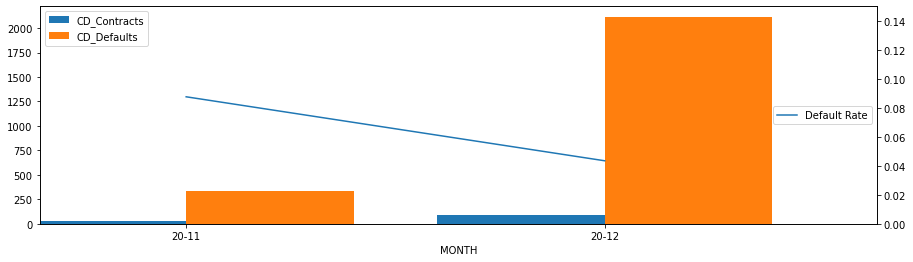

In [55]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [56]:
data["COMBINED_SCORE_WITH_AIRTEL"] = data[hcc_score] - 0.8*data["AIRTEL_SCORE_WOE"]
data["AIRTEL_SCORE_WOE"] = data["AIRTEL_SCORE_WOE"]*-1

In [57]:
FINAL_SCORE = "AIRTEL_SCORE_WOE"
RISK_SCORE = hcc_score
COMBINED_SCORE = "COMBINED_SCORE_WITH_AIRTEL"
TARGET = target

### Gini Chart

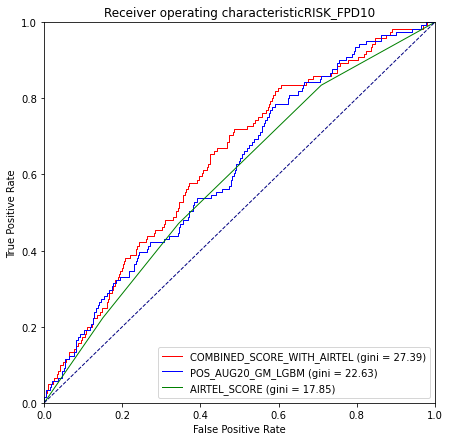

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(data[TARGET],data[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_AIRTEL (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=RISK_SCORE+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic' + TARGET)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [59]:

gini_dic = {}
for x in data["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


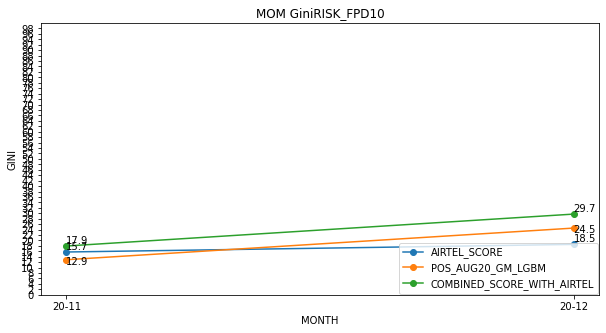

In [60]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[FINAL_SCORE], marker='o', scaley = False, label = "AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = RISK_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[COMBINED_SCORE], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_AIRTEL")

for i, txt in enumerate(gini_df[FINAL_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[FINAL_SCORE][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df[COMBINED_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[COMBINED_SCORE][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini" + TARGET)
plt.show()

## Lifts and Gains Chart

In [61]:
#cum%_bads is gain_score
combined_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=COMBINED_SCORE, bucket=10)
risk_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=RISK_SCORE, bucket=10)
airtel_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=FINAL_SCORE, bucket=10)

### Cumulative Lift Chart 

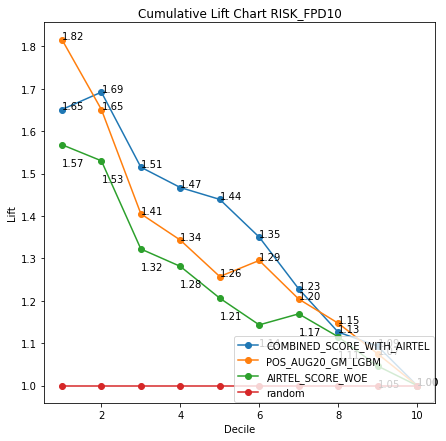

In [62]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


    
ax1.plot(combined_score_lift.index,combined_score_lift["cum_lift"], label = COMBINED_SCORE, marker='o')
for i, txt in enumerate(combined_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_lift.index[i], combined_score_lift["cum_lift"][i+1]))

ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = RISK_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(airtel_score_lift.index,airtel_score_lift["cum_lift"], label = FINAL_SCORE, marker='o')
for i, txt in enumerate(airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (airtel_score_lift.index[i], airtel_score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+TARGET)
plt.show()    


# POS_AUG20_GM_LR

In [63]:
hcc_score='POS_AUG20_GM_LR'
target = 'RISK_FPD10'
observable = 'RISK_AGRF10'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

In [64]:
data = df.dropna(subset = [hcc_score])
data = data[data[observable]==1]

data["MONTH"]= data[TIME_DECISION_DATE].dt.strftime("%y-%m")
data = data[data["MONTH"].isin(['20-11','20-12'])]

In [65]:
df_summ = data.groupby("MONTH").aggregate(["count","sum"])[target]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

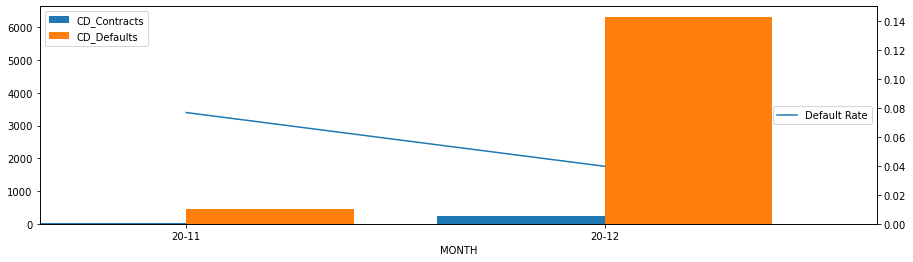

In [66]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [67]:
data["COMBINED_SCORE_WITH_AIRTEL"] = data[hcc_score] - 0.8*data["AIRTEL_SCORE_WOE"]
data["AIRTEL_SCORE_WOE"] = data["AIRTEL_SCORE_WOE"]*-1

In [68]:
FINAL_SCORE = "AIRTEL_SCORE_WOE"
RISK_SCORE = hcc_score
COMBINED_SCORE = "COMBINED_SCORE_WITH_AIRTEL"
TARGET = target

### Gini Chart

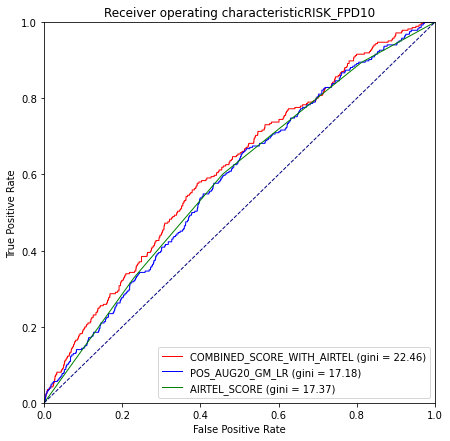

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(data[TARGET],data[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_AIRTEL (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=RISK_SCORE+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic' + TARGET)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [70]:

gini_dic = {}
for x in data["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


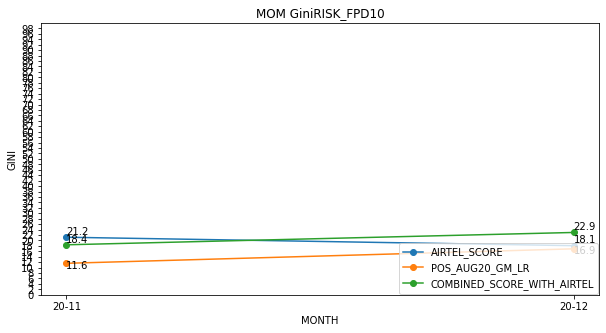

In [71]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[FINAL_SCORE], marker='o', scaley = False, label = "AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = RISK_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[COMBINED_SCORE], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_AIRTEL")

for i, txt in enumerate(gini_df[FINAL_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[FINAL_SCORE][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df[COMBINED_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[COMBINED_SCORE][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini" + TARGET)
plt.show()

## Lifts and Gains Chart

In [72]:
#cum%_bads is gain_score
combined_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=COMBINED_SCORE, bucket=10)
risk_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=RISK_SCORE, bucket=10)
airtel_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=FINAL_SCORE, bucket=10)

### Cumulative Lift Chart 

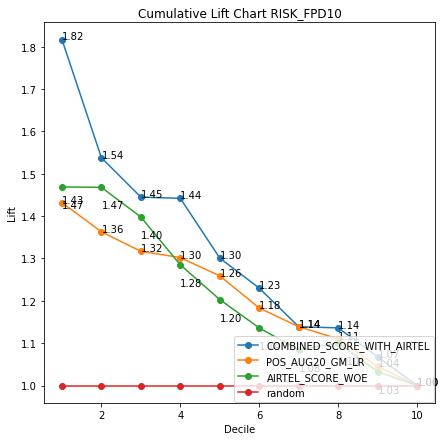

In [73]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


    
ax1.plot(combined_score_lift.index,combined_score_lift["cum_lift"], label = COMBINED_SCORE, marker='o')
for i, txt in enumerate(combined_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_lift.index[i], combined_score_lift["cum_lift"][i+1]))

ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = RISK_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(airtel_score_lift.index,airtel_score_lift["cum_lift"], label = FINAL_SCORE, marker='o')
for i, txt in enumerate(airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (airtel_score_lift.index[i], airtel_score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+TARGET)
plt.show()    


# POS_AUG20_GM_WO_PP_LGBM

In [74]:
hcc_score='POS_AU20_GM_WO_PP_LGBM'
target = 'RISK_FPD10'
observable = 'RISK_AGRF10'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

In [75]:
data = df.dropna(subset = [hcc_score])
data = data[data[observable]==1]

data["MONTH"]= data[TIME_DECISION_DATE].dt.strftime("%y-%m")
data = data[data["MONTH"].isin(['20-11','20-12'])]

In [76]:
df_summ = data.groupby("MONTH").aggregate(["count","sum"])[target]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

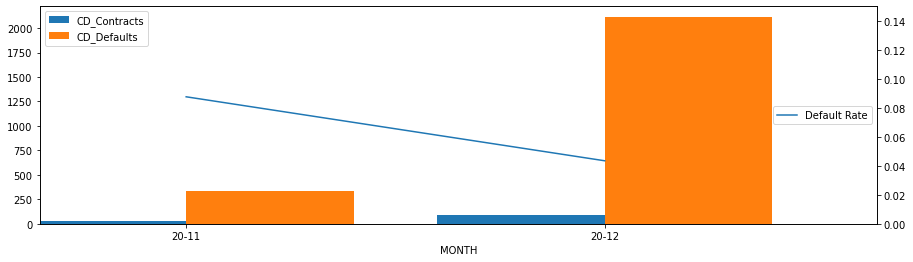

In [77]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [78]:
data["COMBINED_SCORE_WITH_AIRTEL"] = data[hcc_score] - 0.8*data["AIRTEL_SCORE_WOE"]
data["AIRTEL_SCORE_WOE"] = data["AIRTEL_SCORE_WOE"]*-1

In [79]:
FINAL_SCORE = "AIRTEL_SCORE_WOE"
RISK_SCORE = hcc_score
COMBINED_SCORE = "COMBINED_SCORE_WITH_AIRTEL"
TARGET = target

### Gini Chart

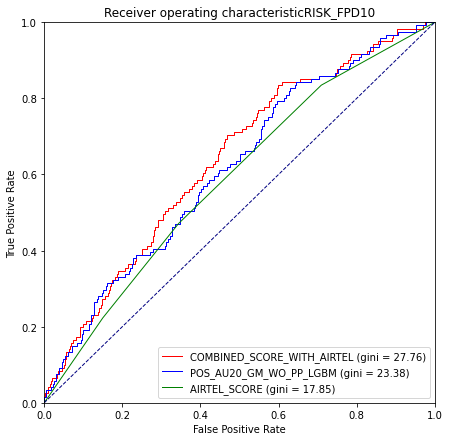

In [80]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(data[TARGET],data[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_AIRTEL (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=RISK_SCORE+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic' + TARGET)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [81]:

gini_dic = {}
for x in data["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


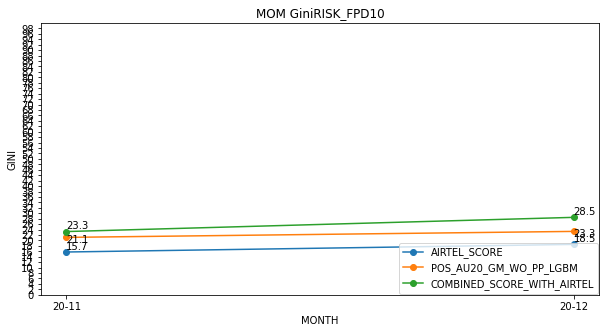

In [82]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[FINAL_SCORE], marker='o', scaley = False, label = "AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = RISK_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[COMBINED_SCORE], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_AIRTEL")

for i, txt in enumerate(gini_df[FINAL_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[FINAL_SCORE][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df[COMBINED_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[COMBINED_SCORE][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini" + TARGET)
plt.show()

## Lifts and Gains Chart

In [83]:
#cum%_bads is gain_score
combined_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=COMBINED_SCORE, bucket=10)
risk_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=RISK_SCORE, bucket=10)
airtel_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=FINAL_SCORE, bucket=10)

### Cumulative Lift Chart 

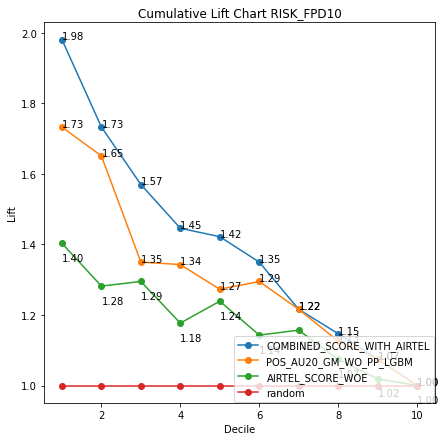

In [84]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


    
ax1.plot(combined_score_lift.index,combined_score_lift["cum_lift"], label = COMBINED_SCORE, marker='o')
for i, txt in enumerate(combined_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_lift.index[i], combined_score_lift["cum_lift"][i+1]))

ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = RISK_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(airtel_score_lift.index,airtel_score_lift["cum_lift"], label = FINAL_SCORE, marker='o')
for i, txt in enumerate(airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (airtel_score_lift.index[i], airtel_score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+TARGET)
plt.show()    


# POS_AUG20_GM_WO_PP_LR

In [85]:
hcc_score='POS_AU20_GM_WO_PP_LR'
target = 'RISK_FPD10'
observable = 'RISK_AGRF10'
TIME_DECISION_DATE = "TIME_DECISION_DATE"

In [86]:
data = df.dropna(subset = [hcc_score])
data = data[data[observable]==1]

data["MONTH"]= data[TIME_DECISION_DATE].dt.strftime("%y-%m")
data = data[data["MONTH"].isin(['20-11','20-12'])]

In [87]:
df_summ = data.groupby("MONTH").aggregate(["count","sum"])[target]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

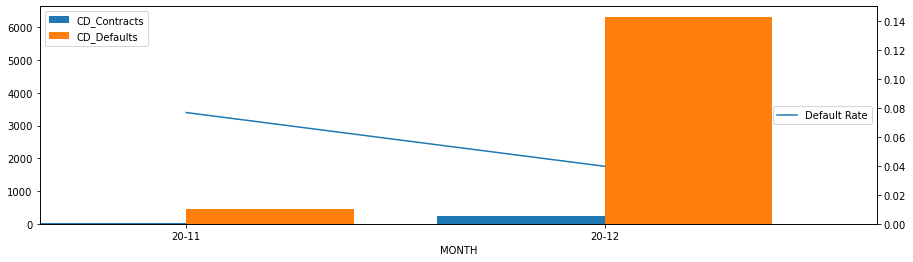

In [88]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [89]:
data["COMBINED_SCORE_WITH_AIRTEL"] = data[hcc_score] - 0.8*data["AIRTEL_SCORE_WOE"]
data["AIRTEL_SCORE_WOE"] = data["AIRTEL_SCORE_WOE"]*-1

In [90]:
FINAL_SCORE = "AIRTEL_SCORE_WOE"
RISK_SCORE = hcc_score
COMBINED_SCORE = "COMBINED_SCORE_WITH_AIRTEL"
TARGET = target

### Gini Chart

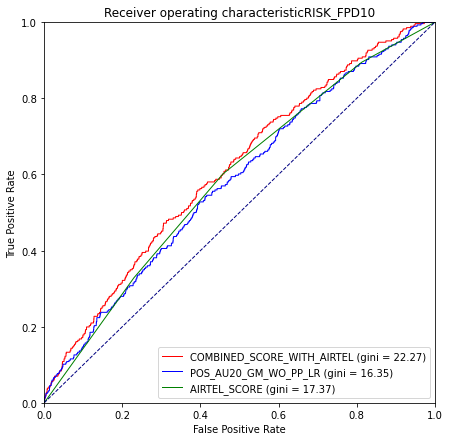

In [91]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(data[TARGET],data[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_AIRTEL (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label=RISK_SCORE+' (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(data[TARGET],data[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic' + TARGET)
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [92]:

gini_dic = {}
for x in data["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(data[data["MONTH"]==x][TARGET],data[data["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


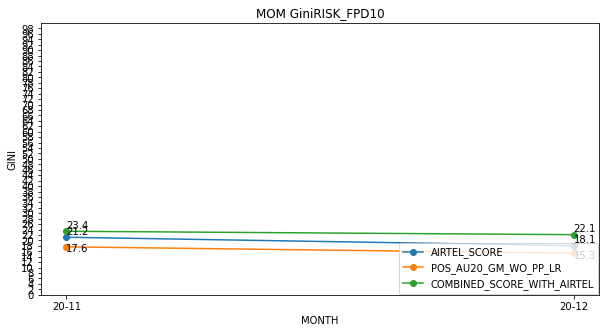

In [93]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df[FINAL_SCORE], marker='o', scaley = False, label = "AIRTEL_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = RISK_SCORE)
ax1.plot(gini_df["MONTH"],gini_df[COMBINED_SCORE], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_AIRTEL")

for i, txt in enumerate(gini_df[FINAL_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[FINAL_SCORE][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df[COMBINED_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[COMBINED_SCORE][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini" + TARGET)
plt.show()

## Lifts and Gains Chart

In [94]:
#cum%_bads is gain_score
combined_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=COMBINED_SCORE, bucket=10)
risk_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=RISK_SCORE, bucket=10)
airtel_score_lift = lift_and_gain_df(data=data,target=TARGET, prob=FINAL_SCORE, bucket=10)

### Cumulative Lift Chart 

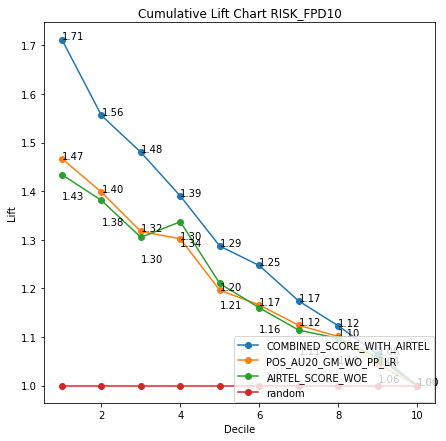

In [95]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


    
ax1.plot(combined_score_lift.index,combined_score_lift["cum_lift"], label = COMBINED_SCORE, marker='o')
for i, txt in enumerate(combined_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_lift.index[i], combined_score_lift["cum_lift"][i+1]))

ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = RISK_SCORE, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(airtel_score_lift.index,airtel_score_lift["cum_lift"], label = FINAL_SCORE, marker='o')
for i, txt in enumerate(airtel_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (airtel_score_lift.index[i], airtel_score_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart "+TARGET)
plt.show()    
